# El Nino - Southern Oscillation

Analysis of FOCI-OpenIFS experiments at varying resolutions
Runs with NEST have an AGRIF nest in North Atlantic. Should not impact ENSO at all, but can be seen as a second ensemble member instead?

In [1]:
# Load what we need
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # this makes for nice distribution plots
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean  # nice colormaps

# EOFs and linear regression
from eofs.xarray import Eof
from scipy.stats import linregress

## ENSO statistics

In [163]:
def calc_nino_index(sst,region='nino34'):
    """
    Calculate a NINO index (default is NINO34)
    The NINO indices are calculated using SST data which is deseasonalised.
    A five-month running mean is applied to the index, which is then also normalised.
    
    Reference:
    https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni
    
    Input:
        
        sst - sea-surface temperature data [xr.DataArray]
        
    Optional:
    
        region - Nino region of interest, e.g. NINO3, NINO34 [string]
        
    Output:
    
        nino_index - Normalised index [xr.DataArray]
    
    """
    
    # Set longitudes, latitudes for region
    if region == 'nino12':
        latmin = -10
        latmax = 0
        lonmin = -90
        lonmax = -80
    
    elif region == 'nino3':
        latmin = -5
        latmax = 5
        lonmin = -150
        lonmax = -90
    
    elif region == 'nino34':
        latmin = -5
        latmax = 5
        lonmin = -170
        lonmax = -120
    
    elif region == 'nino4':
        latmin = -5
        latmax = 5
        lonmin = 160
        lonmax = 210
    
    # Find name of longitude, latitude and time coordinates
    for name in ['lon','longitude','nav_lon']:
        if name in sst.coords:
            lonname = name
    
    for name in ['lat','latitude','nav_lat']:
        if name in sst.coords:
            latname = name
    
    for name in ['time','time_counter']:
        if name in sst.coords:
            timename = name
    
    # Rename variables
    sst = sst.rename({lonname : "lon", latname : "lat", timename : "time"})
    
    # Find min / max of longitude coordinate
    if sst['lon'].min() >= 0 and sst['lon'].max() > 180 and region != 'nino4':
        sst = sst.assign_coords({'lon': (((sst['lon'] + 180) % 360) - 180)})
    
    # If latitude is north-to-south, then reverse latmin and max
    if sst['lat'][0] > sst['lat'][-1]:
        latmin, latmax = latmax, latmin
    
    # Slice the region
    sst_region = sst.sel(lon = slice(lonmin, lonmax), lat = slice(latmin,latmax))
    
    # Remove monthly climatologies
    sst_anom = sst_region.groupby('time.month') - sst_region.groupby('time.month').mean('time')
    
    # Area-weighted average    
    sst_area_mean = (sst_anom * np.cos(sst['lat'] * np.pi / 180.)).mean(('lat', 'lon'))
    
    # Five-month running mean
    sst_roll = sst_area_mean.rolling(time = 5, center = True).mean()
    
    # Normalise
    nino_index = (sst_roll - sst_roll.mean()) / sst_roll.std(ddof = 1)
    
    return nino_index

In [187]:
# HadSST 
hadisst = '/sfs/fs1/work-geomar/smomw352/obs/HadISST_sst_r360x180.nc'
ds_hadsst = xr.open_dataset(hadisst)
# Remove missing values
sst_had = ds_hadsst['sst'].where(ds_hadsst['sst'] > -50)
# Select time period
sst_had = sst_had.sel(time=slice('1970-01-01','2000-01-01'))

# FOCI-LR
foci_lr = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK001_pmpi_1m_19500101_19791231_grid_T_surface_r360x180.nc'
ds_foci_lr = xr.open_dataset(foci_lr)
sst_foci_lr = ds_foci_lr['sosstsst']
sst_foci_lr = sst_foci_lr.rename({"time_counter" : "time"})

# FOCI-LR-NEST
foci_lr_nest = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK002_29_1m_19500101_19791231_grid_T_surface_r360x180.nc'
ds_foci_lr_nest = xr.open_dataset(foci_lr_nest)
sst_foci_lr_nest = ds_foci_lr_nest['sosstsst']
sst_foci_lr_nest = sst_foci_lr_nest.rename({"time_counter" : "time"})

# FOCI-HR-NEST
foci_hr_nest = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK005_6_1m_19500101_19791231_grid_T_surface_r360x180.nc'
ds_foci_hr_nest = xr.open_dataset(foci_hr_nest)
sst_foci_hr_nest = ds_foci_hr_nest['sosstsst']
sst_foci_hr_nest = sst_foci_hr_nest.rename({"time_counter" : "time"})

# FOCI-HR
foci_hr = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK006_3_1m_19500101_19791231_grid_T_surface_r360x180.nc'
ds_foci_hr = xr.open_dataset(foci_hr)
sst_foci_hr = ds_foci_hr['sosstsst']
sst_foci_hr = sst_foci_hr.rename({"time_counter" : "time"})

In [188]:
# Nino indices
nino34_had = calc_nino_index(sst_had)
nino34_foci_lr = calc_nino_index(sst_foci_lr)
nino34_foci_hr = calc_nino_index(sst_foci_hr)
nino34_foci_lr_nest = calc_nino_index(sst_foci_lr_nest)
nino34_foci_hr_nest = calc_nino_index(sst_foci_hr_nest)

/sfs/fs6/home-geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/sfs/fs6/home-geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/sfs/fs6/home-geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/sfs/fs6/home-geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work

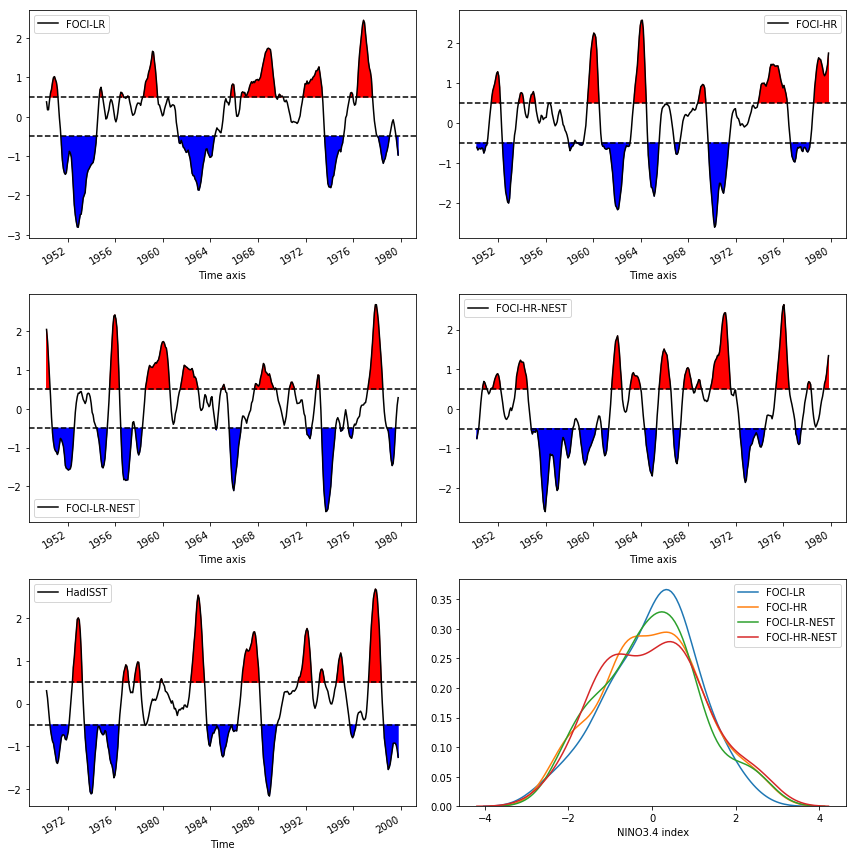

In [190]:
seasons = nino34_foci_lr.time.dt.season

fig, axes = plt.subplots(3,2,figsize=(12,12))
axs = axes.flat

nino = [nino34_foci_lr, nino34_foci_hr, nino34_foci_lr_nest, nino34_foci_hr_nest, nino34_had]
name = ['FOCI-LR', 'FOCI-HR', 'FOCI-LR-NEST', 'FOCI-HR-NEST', 'HadISST']
for i in range(0,5):
    nino[i].plot(ax=axs[i],label=name[i],color='k')
    z1 = np.ma.masked_where(nino[i][:] < 0.5, nino[i][:])
    z2 = np.ma.masked_where(nino[i][:] > -0.5, nino[i][:])
    axs[i].fill_between(nino[i].time.values, 0.5, z1,color='r')
    axs[i].fill_between(nino[i].time.values, -0.5, z2,color='b')

for ax in axs[0:5]:
    ax.axhline(y=0.5,color='k',linestyle='dashed')
    ax.axhline(y=-0.5,color='k',linestyle='dashed')

ax = axs[5]
sns.distplot(nino34_foci_lr.where(seasons == 'DJF').values,ax=ax,kde=True,hist=False,label='FOCI-LR')
sns.distplot(nino34_foci_hr.where(seasons == 'DJF').values,ax=ax,kde=True,hist=False,label='FOCI-HR')
sns.distplot(nino34_foci_lr_nest.where(seasons == 'DJF').values,ax=ax,kde=True,hist=False,label='FOCI-LR-NEST')
sns.distplot(nino34_foci_hr_nest.where(seasons == 'DJF').values,ax=ax,kde=True,hist=False,label='FOCI-HR-NEST')
ax.set_xlabel('NINO3.4 index')

for ax in axs:
    ax.legend()

fig.tight_layout()
fig.savefig('nino34_timeseries_and_dist.eps',format='eps')

## ENSO composites

In [191]:
sst_anom_foci_lr = sst_foci_lr.groupby('time.month') - sst_foci_lr.groupby('time.month').mean('time')
sst_comp_foci_lr = sst_anom_foci_lr.where( nino34_foci_lr > 0.5 ).mean('time') - sst_anom_foci_lr.where( nino34_foci_lr < -0.5 ).mean('time')

sst_anom_foci_hr = sst_foci_hr.groupby('time.month') - sst_foci_hr.groupby('time.month').mean('time')
sst_comp_foci_hr = sst_anom_foci_hr.where( nino34_foci_lr > 0.5 ).mean('time') - sst_anom_foci_hr.where( nino34_foci_hr < -0.5 ).mean('time')

sst_anom_foci_lr_nest = sst_foci_lr_nest.groupby('time.month') - sst_foci_lr_nest.groupby('time.month').mean('time')
sst_comp_foci_lr_nest = sst_anom_foci_lr_nest.where( nino34_foci_lr_nest > 0.5 ).mean('time') - sst_anom_foci_lr_nest.where( nino34_foci_lr_nest < -0.5 ).mean('time')

sst_anom_foci_hr_nest = sst_foci_hr_nest.groupby('time.month') - sst_foci_hr_nest.groupby('time.month').mean('time')
sst_comp_foci_hr_nest = sst_anom_foci_hr_nest.where( nino34_foci_lr_nest > 0.5 ).mean('time') - sst_anom_foci_hr_nest.where( nino34_foci_hr_nest < -0.5 ).mean('time')

da_sst = [sst_comp_foci_lr, sst_comp_foci_hr, sst_comp_foci_lr_nest, sst_comp_foci_hr_nest]

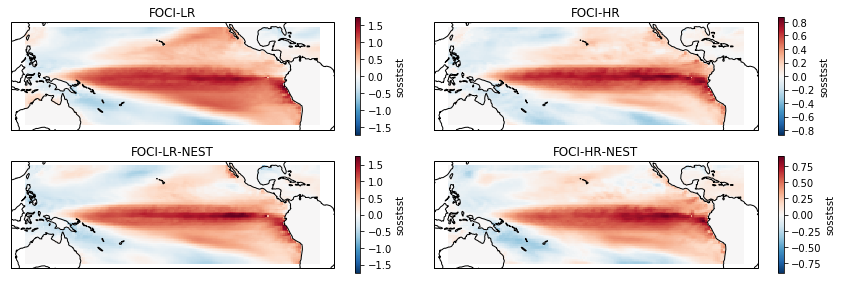

In [192]:
prj = ccrs.PlateCarree(central_longitude=-170)
fig = plt.figure(figsize=(12,4))
axs = []
axs.append( fig.add_subplot(2,2,1,projection=prj) )
axs.append( fig.add_subplot(2,2,2,projection=prj) )
axs.append( fig.add_subplot(2,2,3,projection=prj) )
axs.append( fig.add_subplot(2,2,4,projection=prj) )

name = ['FOCI-LR','FOCI-HR','FOCI-LR-NEST','FOCI-HR-NEST']
for i in range(0,4):
    # Longitudes are [-180, 180]
    # Transform to [0, 360]
    zplot = da_sst[i].assign_coords({'lon': np.where(da_sst[i].lon < 0, da_sst[i].lon + 360, da_sst[i].lon) })
    # Here we see that lon starts at 0 and ends at 359.
    #print(zplot.lon)
    # Slice out the region
    zplot.sel(lon = slice(120,300), lat = slice(-30,30)).plot(ax=axs[i],transform=ccrs.PlateCarree())
    axs[i].set_title(name[i])

for ax in axs:
    ax.coastlines()
    # Setting lon max to > 180 sets lonmin = -180 and lonmax = 180
    #ax.set_extent([120,300,-20,20],crs=prj)
    
fig.tight_layout()
fig.savefig('sst_composite_enso.png',format='png',dpi=300)

In [194]:
# FOCI-LR
foci_lr = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK001_pmpi_1m_19500101_19791231_GG_surface_r360x180.nc'
ds_foci_lr = xr.open_dataset(foci_lr)

# FOCI-LR-NEST
foci_lr_nest = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK002_29_1m_19500101_19791231_GG_surface_r360x180.nc'
ds_foci_lr_nest = xr.open_dataset(foci_lr_nest)

# FOCI-HR-NEST
foci_hr_nest = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK005_6_1m_19500101_19791231_GG_surface_r360x180.nc'
ds_foci_hr_nest = xr.open_dataset(foci_hr_nest)

# FOCI-HR
foci_hr = '/sfs/fs1/work-geomar/smomw352/foci_analysis/foci_JJK006_3_1m_19500101_19791231_GG_surface_r360x180.nc'
ds_foci_hr = xr.open_dataset(foci_hr)

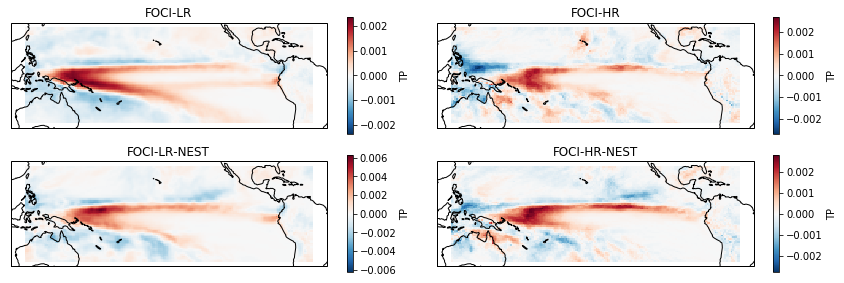

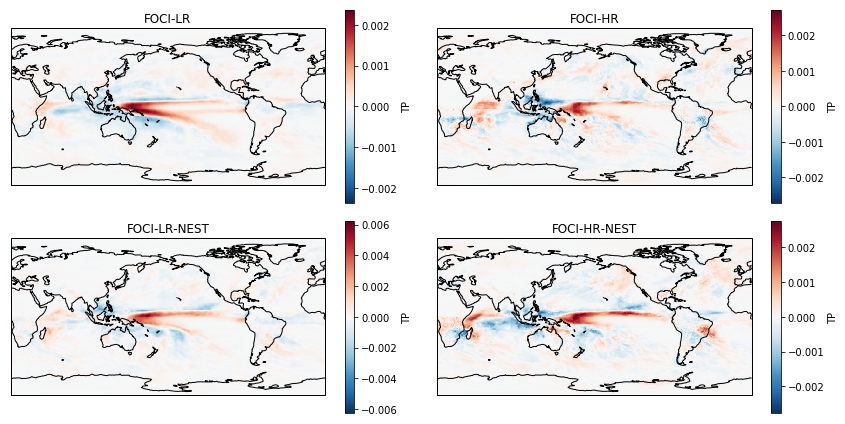

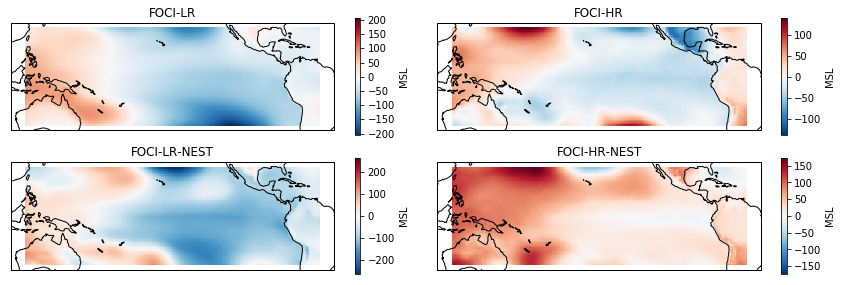

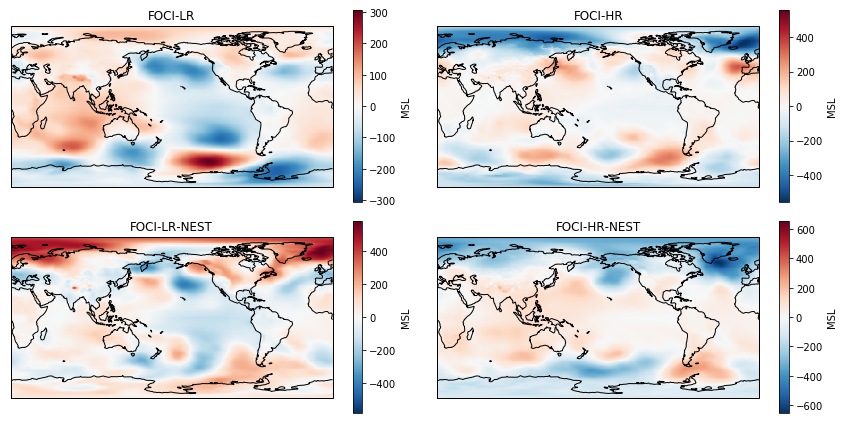

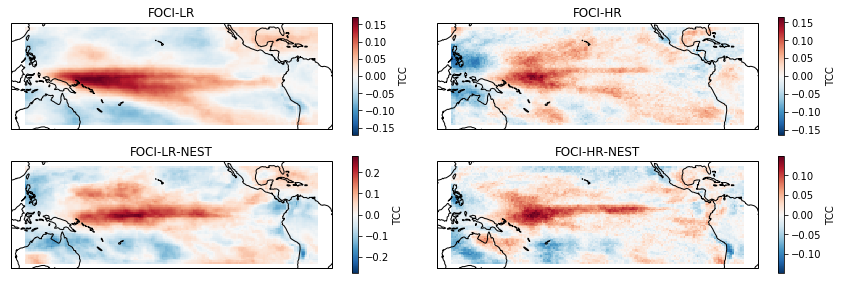

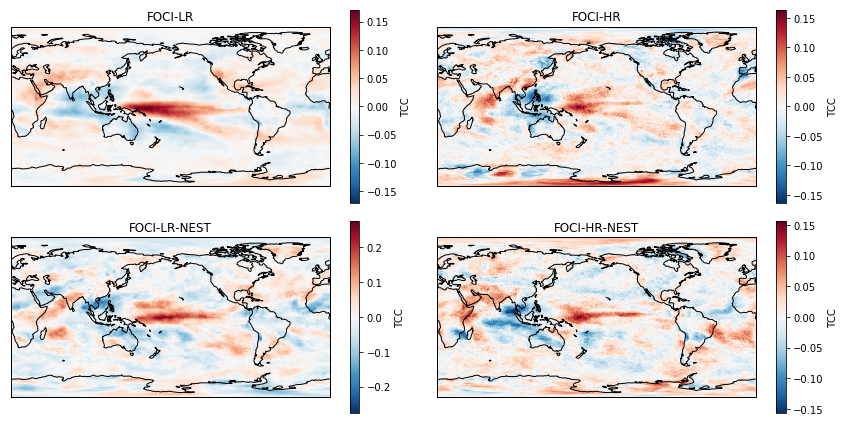

In [210]:
for atm_var in ['TP','MSL','TCC']:
    anom_foci_lr = ds_foci_lr[atm_var].groupby('time.month') - ds_foci_lr[atm_var].groupby('time.month').mean('time')
    ind1 = np.where(nino34_foci_lr > 0.5)[0]
    ind2 = np.where(nino34_foci_lr < -0.5)[0]
    comp_foci_lr = anom_foci_lr[ind1,:,:].mean('time').fillna(0) - anom_foci_lr[ind2,:,:].mean('time').fillna(0)
    
    anom_foci_hr = ds_foci_hr[atm_var].groupby('time.month') - ds_foci_hr[atm_var].groupby('time.month').mean('time')
    comp_foci_hr = anom_foci_hr.where( nino34_foci_lr > 0.5 ).mean('time').fillna(0) - anom_foci_hr.where( nino34_foci_hr < -0.5 ).mean('time').fillna(0)
    
    anom_foci_lr_nest = ds_foci_lr_nest[atm_var].groupby('time.month') - ds_foci_lr_nest[atm_var].groupby('time.month').mean('time')
    comp_foci_lr_nest = anom_foci_lr_nest.where( nino34_foci_lr_nest > 0.5 ).mean('time').fillna(0) - anom_foci_lr_nest.where( nino34_foci_lr_nest < -0.5 ).mean('time').fillna(0)
    
    anom_foci_hr_nest = ds_foci_hr_nest[atm_var].groupby('time.month') - ds_foci_hr_nest[atm_var].groupby('time.month').mean('time')
    comp_foci_hr_nest = anom_foci_hr_nest.where( nino34_foci_lr_nest > 0.5 ).mean('time').fillna(0) - anom_foci_hr_nest.where( nino34_foci_hr_nest < -0.5 ).mean('time').fillna(0)
    
    da = [comp_foci_lr, comp_foci_hr, comp_foci_lr_nest, comp_foci_hr_nest]
    
    prj = ccrs.PlateCarree(central_longitude=-170)
    fig1 = plt.figure(figsize=(12,4)) 
    axs1 = []
    axs1.append( fig1.add_subplot(2,2,1,projection=prj) )
    axs1.append( fig1.add_subplot(2,2,2,projection=prj) )
    axs1.append( fig1.add_subplot(2,2,3,projection=prj) )
    axs1.append( fig1.add_subplot(2,2,4,projection=prj) )
    
    prj = ccrs.PlateCarree(central_longitude=-170)
    fig2 = plt.figure(figsize=(12,6)) 
    axs2 = []
    axs2.append( fig2.add_subplot(2,2,1,projection=prj) )
    axs2.append( fig2.add_subplot(2,2,2,projection=prj) )
    axs2.append( fig2.add_subplot(2,2,3,projection=prj) )
    axs2.append( fig2.add_subplot(2,2,4,projection=prj) )
    
    name = ['FOCI-LR','FOCI-HR','FOCI-LR-NEST','FOCI-HR-NEST']
    for i in range(0,4):
        da[i].sel(lon = slice(120,300), lat = slice(-30,30)).plot(ax=axs1[i],transform=ccrs.PlateCarree())
        axs1[i].set_title(name[i])
        
        da[i].plot(ax=axs2[i],transform=ccrs.PlateCarree())
        axs2[i].set_title(name[i])
    
    for ax in axs1:
        ax.coastlines()
        
    for ax in axs2:
        ax.coastlines()
    
    fig1.tight_layout()
    fig2.tight_layout()
    fig.savefig('%s_composite_enso.png' % (atm_var,),format='png',dpi=300)